# Better UMAP model

 
- **Workflow:**
 1. Load libraries and set parameters.  
 2. Detect spikes and bursts per sweep.  
 3. Define segments (bursts vs. non-bursts).  
 4. Compute segment-level metrics and classify bursts.  
 5. Save results to CSV.  
 6. Visualize features using UMAP and distribution plots.


- **Load Libraries**

 `pyabf`: read ABF files (Axon Binary Format).  
 `numpy`, `pandas`: numerical operations and dataframes.  
 `scipy.stats` & `scipy.signal`: compute statistics, detect peaks, Hilbert transform.  
 `numpy.linalg.lstsq`: quadratic fit for parabolic bursts.  
 `sklearn.metrics.r2_score`: goodness of fit for parabolic fit.  
 `umap`, `StandardScaler`: dimensionality reduction for visualization.  
 `matplotlib`, `seaborn`, `plotly`: plotting tools.

In [32]:
import os
import pyabf
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks, hilbert
from numpy.linalg import lstsq
from sklearn.metrics import r2_score
%matplotlib widget

import umap
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

- **Parameters**
 
  Folder path, spike detection threshold, burst ISI threshold.  
  Sampling frequency and derived time step.  
  Burst classification criteria: minimum spikes, maximum ISI, minimum spike rate.

In [33]:
folder_path = "bursting"      # Folder containing ABF files
threshold = -35               # Voltage threshold (mV) for spike detection
burst_threshold = 0.3         # Maximum ISI to be considered in the same burst (s)
fs = 10000                    # Sampling frequency (Hz)
dt = 1 / fs                   # Time step (s)

min_spikes_in_burst = 4       # Min spikes per burst
max_isi = 0.3                 # Max ISI inside burst
min_spike_rate = 5            # Min spike rate in Hz

all_segment_metrics = []      # Store computed metrics

- **Collect ABF files**

Gather all `.abf` files in the folder for batch processing.

In [34]:
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

- **Loop over ABF files and sweeps**

 For each sweep:
 1. Detect spikes using `find_peaks`.  
 2. Detect bursts based on ISI and minimum spike criteria.  
 3. Define segments (bursts and non-bursts).  
 4. Classify bursts into types (Square Wave, Parabolic, Other) using voltage comparisons and parabolic fits.  
 5. Compute segment metrics: spike count, ISI, mean, std, skewness, kurtosis, area, derivative features.  
 6. Append all metrics to `all_segment_metrics`.

In [35]:
for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX
        voltage = abf.sweepY

        # Spike detection
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs

        # Burst detection
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)
            current_burst = [spike_times[0]]
            for i in range(1, len(spike_times)):
                if isi[i-1] < burst_threshold:
                    current_burst.append(spike_times[i])
                else:
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

        # Define segments (bursts and non-bursts)
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))
        if bursts:
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            for i in range(len(bursts)-1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            segments.append((time[0], time[-1], "Non-burst"))

        # Classify bursts into types
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]
                seg_time = time[seg_mask]

                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    inter_mask_prev = (time > segments[i-1][1]) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    inter_mask_next = (time > seg_end) & (time < segments[i+1][0])
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])

                burst_min = np.min(seg_voltage)

                # Parabolic fit for burst shape
                t = np.linspace(-0.5, 0.5, len(seg_voltage))
                X = np.vstack([t**2, t, np.ones_like(t)]).T
                coef, *_ = lstsq(X, seg_voltage, rcond=None)
                y_hat = X @ coef
                r2_parabola = r2_score(seg_voltage, y_hat)

                # Hilbert envelope symmetry
                analytic_signal = hilbert(seg_voltage)
                envelope = np.abs(analytic_signal)
                half = len(envelope) // 2
                symmetry = (np.corrcoef(envelope[:half], envelope[-half:][::-1])[0, 1]
                            if half >= 2 else np.nan)

                seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
                spike_rate = len(seg_peaks) / (seg_end - seg_start)

                # Burst classification rules
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        # Compute segment metrics
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)

            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\3739366828.py:61: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\3739366828.py:61: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\3739366828.py:61: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\3739366828.py:61: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\3739366828.py:61: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\3739366828.py:61: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\3739366828.py:61: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\3739366828.py:61: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\3739366828.py:61: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\373936

- **Save Results to CSV**

In [36]:
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurtosis_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)

- **Visualization: UMAP & Distributions**
 
  Standardize features and reduce dimensionality with UMAP.  
  Plot 2D embedding colored by burst type.  
  Histogram of segment durations by burst type.  
  Optional interactive UMAP plot using Plotly.

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



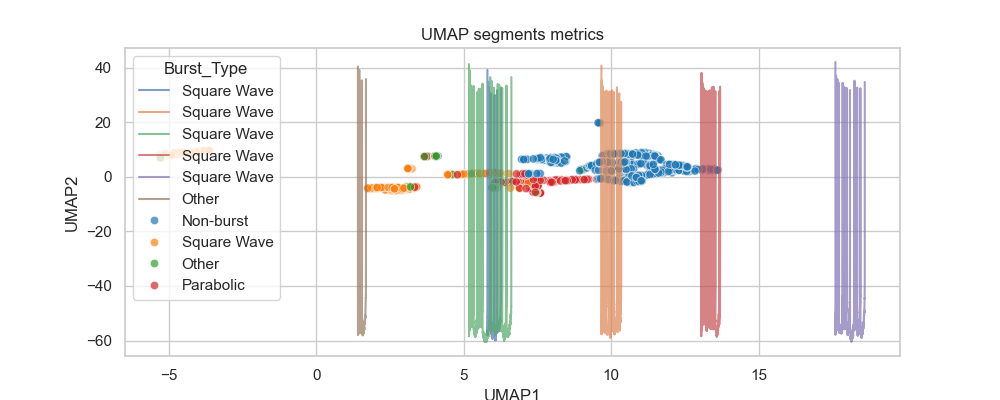

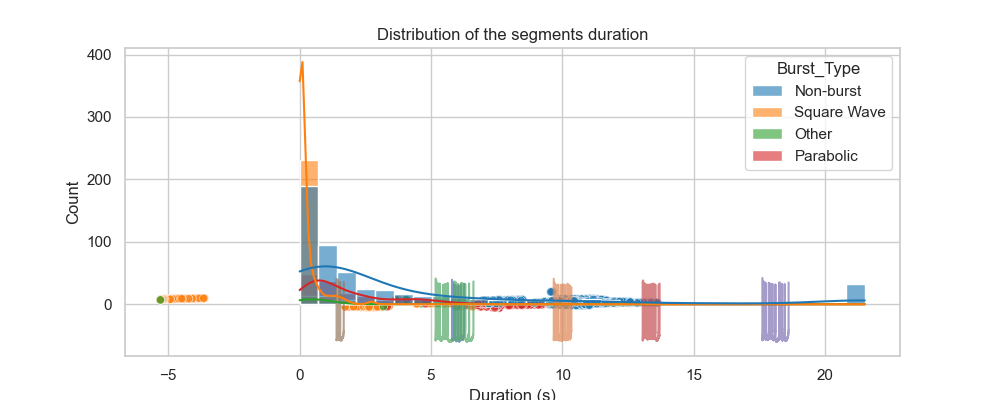

In [37]:

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
df = pd.read_csv("segment_voltage_metrics_with_ISI_and_peaks.csv")

header = list(df)[4:]  # Ignore metadata columns
X = np.array(df[header])
y = np.array(df.Burst_Type)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y

sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", 
                hue="Burst_Type", palette="tab10", alpha=0.7)
plt.title("UMAP segments metrics")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

sns.set(style="whitegrid", context="notebook", rc={'figure.figsize':(10,6)})
sns.histplot(data=df_segments, x="Duration", hue="Burst_Type",
             bins=30, kde=True, palette="tab10", alpha=0.6)
plt.title("Distribution of the segments duration")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()

fig = px.scatter(df_umap, x="UMAP1", y="UMAP2", color="Burst_Type", title="UMAP")
pio.renderers.default = "browser"
fig.show()

# UMAP Conflict Analysis of Burst Types

 After embedding segments in 2D using UMAP, we want to:
 1. Compute **centroids** of each burst type cluster.  
 2. Identify **potential overlaps** between clusters based on centroid distances.  
 3. Detect **individual points in mixed regions** (neighbors of different types).  
 4. Visualize **conflict points** on the UMAP embedding.  
 
 This helps understand which bursts are ambiguous or poorly separated in the UMAP space.

- **Load Libraries**
 
 - `scipy.spatial.distance`: compute pairwise Euclidean distances between centroids.  
 - `sklearn.neighbors.NearestNeighbors`: identify points close to neighbors of other types.  
 - `%matplotlib widget`: interactive plots in Jupyter.


In [38]:
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
%matplotlib widget

- **Add index for traceability**

 Adding the original DataFrame index to `df_umap` allows us to trace points back to the raw segment metrics later.

In [39]:
df_umap["Index"] = df.index

 - **Calculate centroids of each burst type**
 
 Compute the **mean UMAP1 and UMAP2 coordinates** for each burst type cluster.

In [40]:
centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()


Distance between centroids of burst types:
Burst_Type   Non-burst     Other  Parabolic  Square Wave
Burst_Type                                              
Non-burst     0.000000  6.982493   6.356981     9.964681
Other         6.982493  0.000000   5.053357     2.984769
Parabolic     6.356981  5.053357   0.000000     7.086916
Square Wave   9.964681  2.984769   7.086916     0.000000

Overlap threshold (UMAP distance): 3.192

Potentially overlapping burst type pairs:
[('Other', 'Square Wave')]

Number of segments in conflict regions: 147
Burst_Type
Non-burst      17
Other          21
Parabolic      73
Square Wave    36
dtype: int64


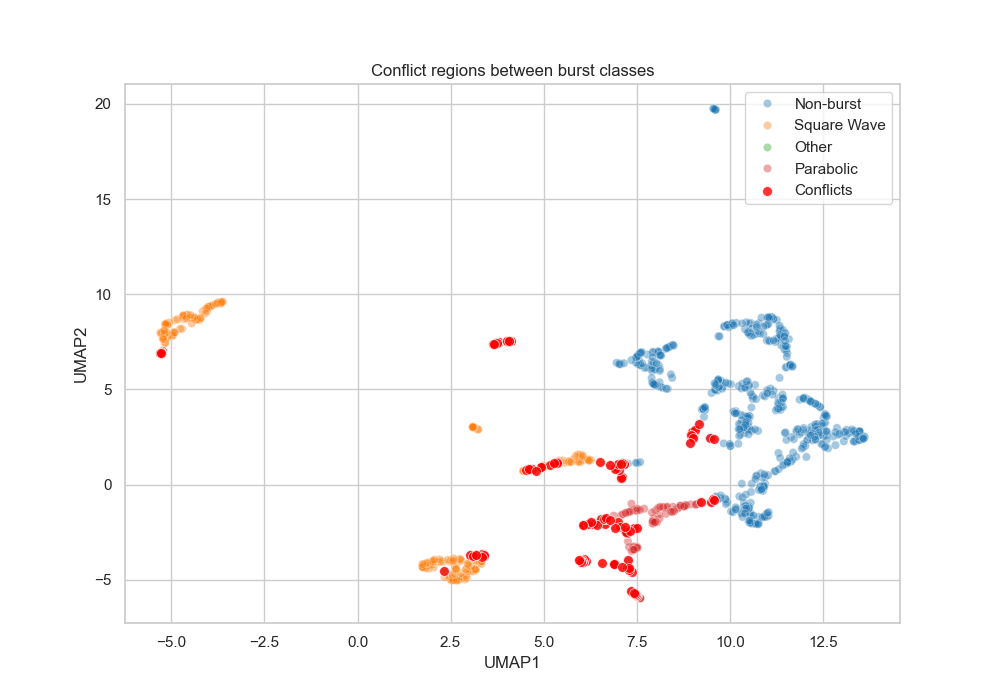

In [41]:
# Compute distance matrix between centroids

# Pairwise Euclidean distances between centroids.  
# Helps identify which burst types are closer than expected and may overlap in UMAP space.

dist_matrix = distance.cdist(centroids.values, centroids.values)
dist_df = pd.DataFrame(dist_matrix, index=centroids.index, columns=centroids.index)

print("\nDistance between centroids of burst types:")
print(dist_df)

# Define a threshold for potential overlap: 10% of the smallest nonzero distances.


threshold = np.percentile(dist_matrix[dist_matrix > 0], 10)
print(f"\nOverlap threshold (UMAP distance): {threshold:.3f}")


# Identify pairs of burst types whose centroids are closer than the threshold.

close_pairs = []
for i, type_i in enumerate(centroids.index):
    for j, type_j in enumerate(centroids.index):
        if j > i and dist_matrix[i, j] < threshold:
            close_pairs.append((type_i, type_j))

print("\nPotentially overlapping burst type pairs:")
print(close_pairs)

# Detect individual points in mixed regions

# Build a nearest-neighbors model.  
# For each point, check if it has neighbors from a different burst type.  
# Points with at least one neighbor of a different type are considered conflict points.

X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values

nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):
        conflict_indices.append(df_umap.iloc[i]["Index"])

conflicts_df = df_segments.iloc[conflict_indices]

print(f"\nNumber of segments in conflict regions: {len(conflicts_df)}")
print(conflicts_df.groupby("Burst_Type").size())
# Plot conflict points on UMAP embedding
 
# Plot all points transparent by burst type.  
# Overlay conflict points in red for clarity.  
# Interactive exploration can help visually assess ambiguous regions.

plt.figure(figsize=(10, 7))

# Plot all points (transparent)
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", 
                hue="Burst_Type", alpha=0.4, palette="tab10")

# Overlay conflict points
sns.scatterplot(data=df_umap.iloc[conflict_indices], x="UMAP1", y="UMAP2", 
                color="red", s=50, label="Conflicts", alpha=0.8)

plt.legend()
plt.title("Conflict regions between burst classes")
plt.show()


- **Visualizing Conflicting Segments**

 After detecting segments that reside in conflict regions in UMAP space, it is often useful to inspect the raw voltage traces to understand why these bursts are ambiguous.  
 
 In this example, we will plot the first three conflicting segments to examine their waveforms.


- **Loop over the first 3 conflicting segments**

 - `conflicts_df.head(3).index`: selects the first 3 rows from the conflict segments DataFrame.  
 - For each segment, we will:
   1. Load the corresponding ABF file.  
   2. Select the sweep containing the segment.  
   3. Plot the voltage trace for inspection.

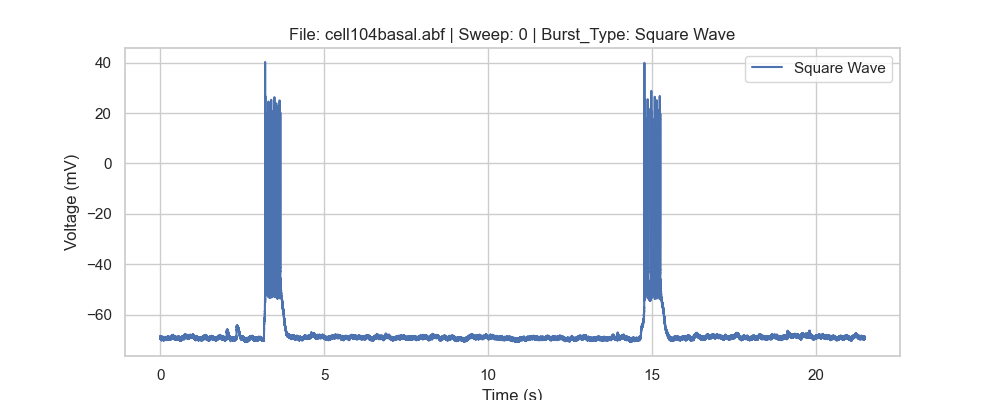

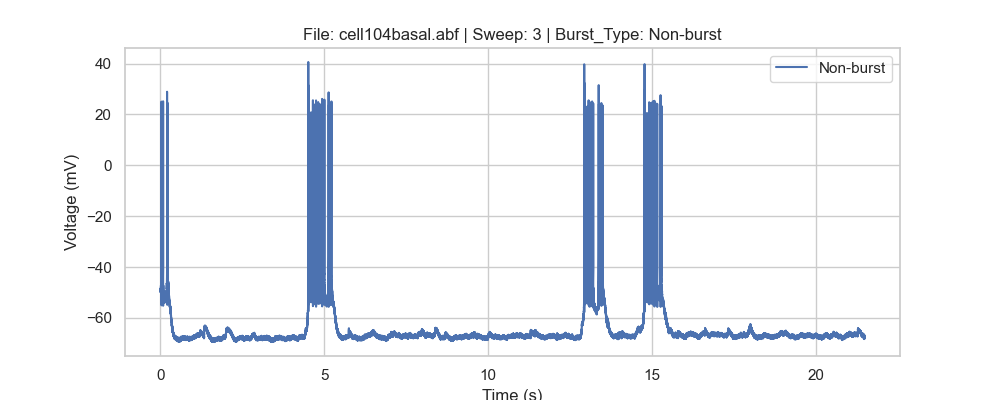

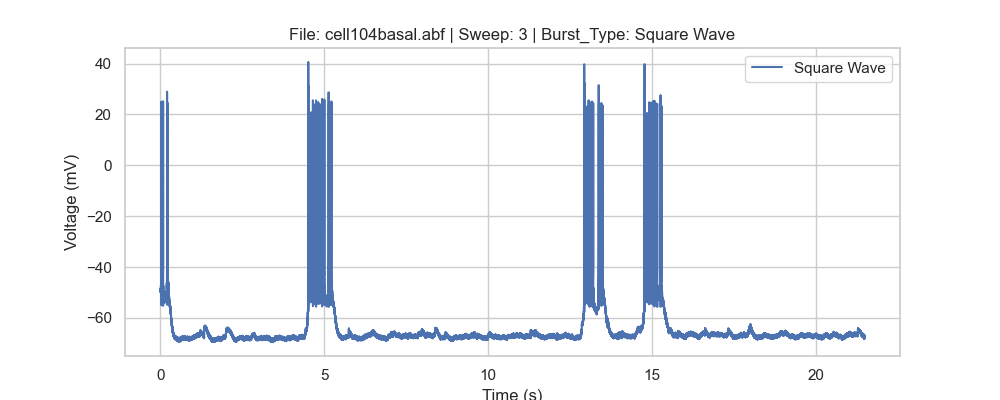

In [42]:
for idx in conflicts_df.head(3).index:
    row = conflicts_df.loc[idx]                     # Get all information for this conflict segment
    
    # Load the original ABF file for this segment
    file_path = os.path.join(folder_path, row["File_Name"])
    abf = pyabf.ABF(file_path)
    
    # Select the sweep containing this conflicting segment
    abf.setSweep(row["Sweep"])
    time = abf.sweepX
    voltage = abf.sweepY
    
    # Define mask for the sweep (here we use the full sweep; can refine to the segment start/end)
    mask = (time >= 0) & (time <= time[-1])
    
    # Plot the sweep
    plt.figure(figsize=(10, 4))
    plt.plot(time[mask], voltage[mask], label=f"{row['Burst_Type']}")
    plt.title(f"File: {row['File_Name']} | Sweep: {row['Sweep']} | Burst_Type: {row['Burst_Type']}")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.legend()
    plt.show()

# Detecting Conflicts Between Burst Classes in UMAP Space

After performing UMAP dimensionality reduction on burst metrics, some segments may reside in "mixed regions" where bursts of different types overlap.  
These points are "conflicts" and need special inspection.  

- **This notebook section will:**
 1. Compute centroids of each burst type in UMAP space.  
 2. Identify potentially overlapping burst types.  
 3. Detect individual conflict points using nearest neighbors.  
 4. Visualize conflict regions.  
 5. Plot time-series for the first few conflicting segments.  
 6. Save conflict information for future analysis.


Potentially overlapping burst type pairs (by centroids):
[('Other', 'Square Wave')]

Number of segments in conflict regions: 147
Burst_Type
Non-burst      17
Other          21
Parabolic      73
Square Wave    36
dtype: int64


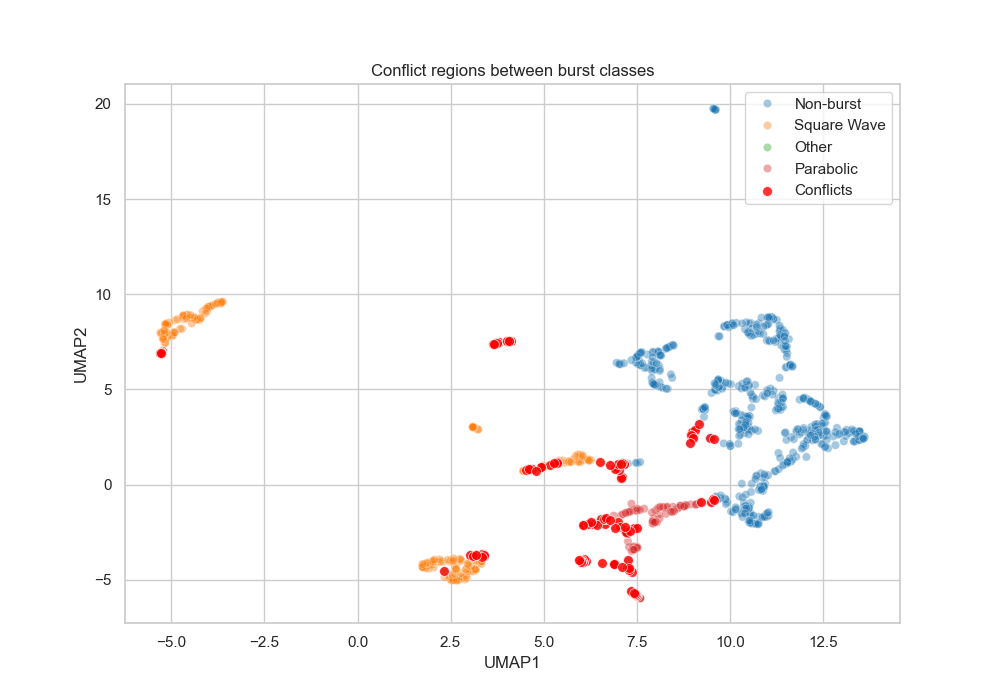

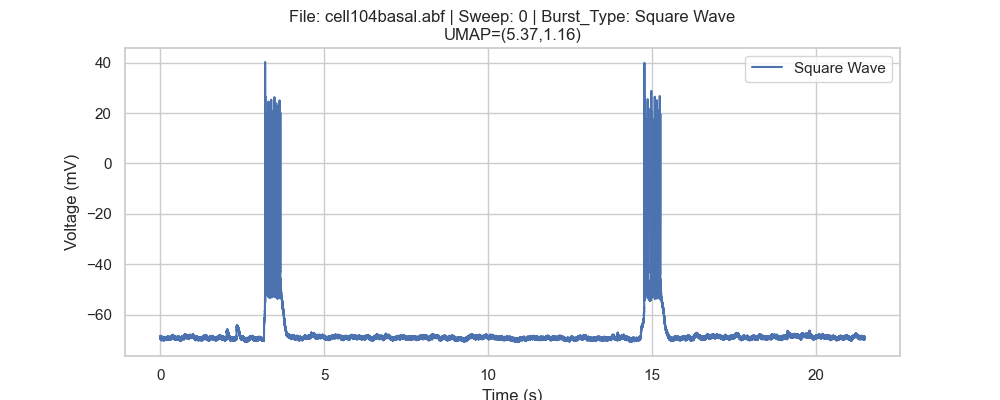

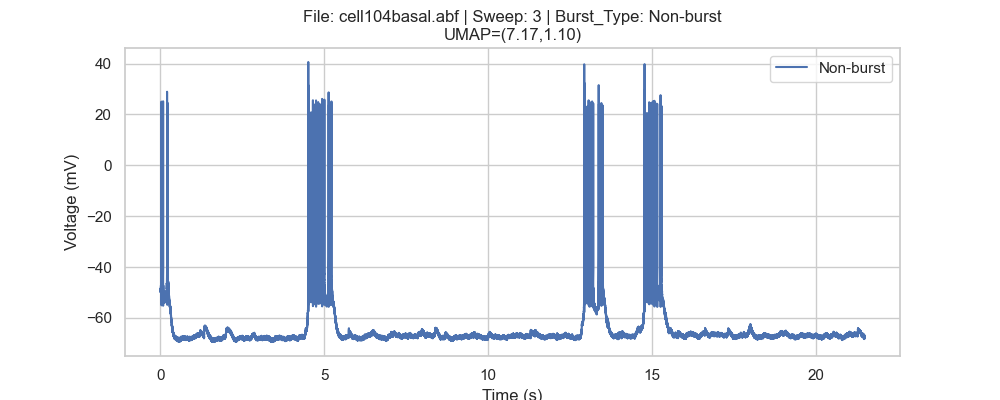

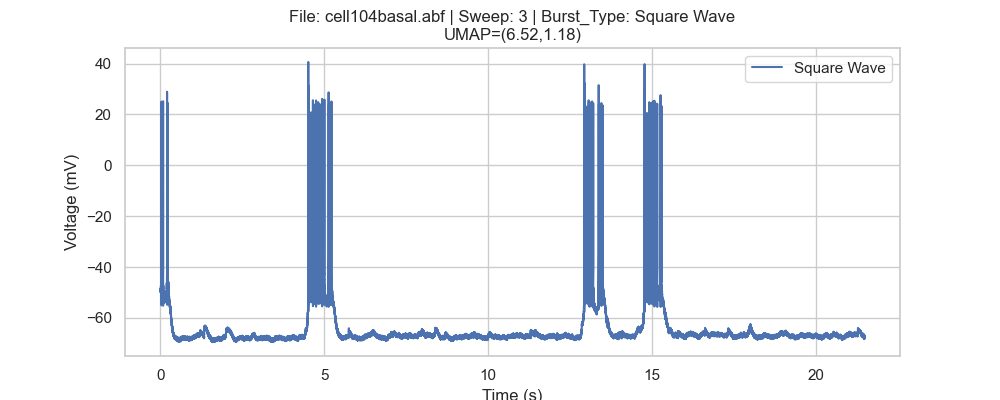


File 'conflict_segments_with_umap.csv' saved with metrics and UMAP coordinates of conflict points.


In [43]:
# Add Index to Link UMAP Data with Original Segment Metrics
# Each UMAP row gets an index referencing "df_segments", allowing retrieval of raw voltage data later.
df_umap["Index"] = df.index  # Add index for traceability


# Compute Centroids and Identify Close Burst Types

# - Centroids: mean UMAP1/UMAP2 coordinates per burst type.  
# - Distance matrix: pairwise Euclidean distances between centroids.  
# - Threshold: 10th percentile of shortest distances (excluding zero).  
# - `close_pairs`: burst type pairs whose centroids are unusually close (potential overlap).


# Compute centroids of each burst type
centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()

# Distance matrix between all centroids
dist_matrix = distance.cdist(centroids.values, centroids.values)

# Threshold = 10% of the shortest nonzero distances
threshold = np.percentile(dist_matrix[dist_matrix > 0], 10)

# Identify potentially overlapping burst type pairs
close_pairs = []
for i, type_i in enumerate(centroids.index):
    for j, type_j in enumerate(centroids.index):
        if j > i and dist_matrix[i, j] < threshold:
            close_pairs.append((type_i, type_j))

print("\nPotentially overlapping burst type pairs (by centroids):")
print(close_pairs)


# Detect Conflicting Points Using Nearest Neighbors

# - For each point, we find its 8 nearest neighbors in UMAP space.  
# - If a neighbor belongs to a different burst type, the point is marked as a "conflict".  
# - "conflict_data" combines UMAP coordinates and original metrics for analysis.


X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values

# Build nearest-neighbors model (8 neighbors per point)
nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

# Identify conflict points
conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Extract metrics and UMAP coordinates
conflicts_df = df_segments.iloc[conflict_indices]
conflict_umap_coords = df_umap.iloc[conflict_indices][["UMAP1", "UMAP2", "Burst_Type"]]

# Remove duplicate columns before joining
conflict_umap_coords_nodup = conflict_umap_coords.drop(columns=["Burst_Type"])
conflict_data = conflicts_df.copy()
conflict_data = conflict_data.join(conflict_umap_coords_nodup.set_index(conflict_data.index))

print(f"\nNumber of segments in conflict regions: {len(conflict_data)}")
print(conflict_data.groupby("Burst_Type").size())


# Plot UMAP with Conflicts Highlighted

# - All points: semi-transparent, colored by burst type.  
# - Conflict points: overlaid in "red" for easy identification.

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", alpha=0.4, palette="tab10")
sns.scatterplot(data=conflict_umap_coords, x="UMAP1", y="UMAP2",
                color="red", s=50, label="Conflicts", alpha=0.8)
plt.legend()
plt.title("Conflict regions between burst classes")
plt.show()


# Plot Time-Series for the First N Conflicting Segments

# - Visualize raw voltage traces to investigate why these bursts are ambiguous.  
# - Titles include file, sweep, burst type, and UMAP coordinates.

N = 3  # Number of conflicts to plot
for idx in conflict_data.head(N).index:
    row = conflict_data.loc[idx]
    file_path = os.path.join(folder_path, row["File_Name"])
    abf = pyabf.ABF(file_path)
    abf.setSweep(row["Sweep"])
    time = abf.sweepX
    voltage = abf.sweepY

    seg_start = time.min()
    seg_end = time.max()
    mask = (time >= seg_start) & (time <= seg_end)

    plt.figure(figsize=(10, 4))
    plt.plot(time[mask], voltage[mask], label=f"{row['Burst_Type']}")
    plt.title(f"File: {row['File_Name']} | Sweep: {row['Sweep']} | Burst_Type: {row['Burst_Type']}\nUMAP=({row['UMAP1']:.2f},{row['UMAP2']:.2f})")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.legend()
    plt.show()


# Save Conflict Results

# - Save metrics and UMAP coordinates of conflict points for later inspection or further analysis.
conflict_data.to_csv("conflict_segments_with_umap.csv", index=False)
print("\nFile 'conflict_segments_with_umap.csv' saved with metrics and UMAP coordinates of conflict points.")

# ABF Burst Analysis with UMAP Conflict Detection

- **This notebook section:**
 1. Loads ABF files and detects bursts using a voltage threshold and ISI criteria.  
 2. Computes segment metrics including voltage statistics and derivative statistics.  
 3. Performs UMAP dimensionality reduction to visualize bursts in 2D.  
 4. Identifies conflict regions in UMAP space (cells with mixed burst types).  
 5. Plots individual conflict pairs and overlays all segments in conflicting UMAP bins.


- **Libraries and Configuration**
 
  `pyabf` to read ABF electrophysiology files.  
  `numpy`, `pandas` for data handling.  
  `scipy` for spike detection and statistics.  
  `umap` for dimensionality reduction.  
  `matplotlib` for plotting.

In [44]:
import os
import pyabf
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt

# Configuration
folder_path = "bursting"       # Folder containing ABF files
threshold = -35                # Spike detection threshold (mV)
burst_threshold = 0.3          # Max ISI to include spikes in the same burst (s)
fs = 10000                     # Sampling frequency (Hz)
dt = 1 / fs
min_spikes_in_burst = 4        # Minimum spikes per burst
bin_size = 0.5                 # UMAP grid size for conflict detection
N = 3                          # Number of conflict pairs to plot

all_segment_metrics = []       # Storage for all segment metrics

- **Load ABF Files, Detect Bursts, and Compute Metrics**
 
   Detect spikes with a threshold.  
   Detect bursts: groups of spikes with ISI < `burst_threshold` and ≥ `min_spikes_in_burst`.  
   Segment sweeps into bursts and non-bursts.  
   Classify bursts: Square Wave, Parabolic, or Other (based on min voltage relative to surrounding baseline).  
   Compute segment metrics: voltage stats, spike stats, and derivative stats.

In [45]:
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX
        voltage = abf.sweepY

        # Spike detection
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs

        # Burst detection
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)
            current_burst = [spike_times[0]]
            for i in range(1, len(spike_times)):
                if isi[i-1] < burst_threshold:
                    current_burst.append(spike_times[i])
                else:
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

        # Segment sweeps into bursts and non-bursts
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        if bursts:
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            for i in range(len(bursts)-1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            segments.append((time[0], time[-1], "Non-burst"))

        # Classify bursts and compute metrics
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # Baseline before/after burst
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])

                burst_min = np.min(seg_voltage)

                # Simple burst classification
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        # Compute metrics for each segment
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)

                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, seg_start, seg_end, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])

C:\Users\manur\AppData\Local\Temp\ipykernel_2772\2296984253.py:66: RuntimeWarning:

Mean of empty slice



- **Create DataFrame and Apply UMAP**

  Store segment metrics in `df_segments`.  
  Scale numerical features before UMAP.  
  Embed in 2D UMAP space.

In [46]:
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type",
    "Segment_Start", "Segment_End", "Duration",
    "Num_Peaks", "Mean_ISI", "Mean", "Std", "Min", "Max",
    "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv",
    "Skewness_Deriv", "Kurtosis_Deriv"
])

header = ["Duration", "Num_Peaks", "Mean_ISI",
          "Mean", "Std", "Min", "Max",
          "Skewness", "Kurtosis", "Area",
          "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv",
          "Skewness_Deriv", "Kurtosis_Deriv"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_segments[header])

reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)
df_segments["UMAP1"] = embedding[:, 0]
df_segments["UMAP2"] = embedding[:, 1]

df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)
print(f"CSV saved with {len(df_segments)} segments and UMAP coordinates.")

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



CSV saved with 951 segments and UMAP coordinates.


- **Detect Conflicts in UMAP Space**

   Divide UMAP space into bins.  
   Identify bins containing more than one burst type.  
   Extract segments in conflict bins.

In [47]:
df_segments["UMAP_bin"] = (
    (df_segments["UMAP1"] // bin_size).astype(int).astype(str) + "_" +
    (df_segments["UMAP2"] // bin_size).astype(int).astype(str)
)

conflict_bins = df_segments.groupby("UMAP_bin")["Burst_Type"].nunique()
conflict_bins = conflict_bins.loc[lambda x: x > 1].index
conflict_data = df_segments[df_segments["UMAP_bin"].isin(conflict_bins)]
print(f"{len(conflict_data)} segments are in conflict regions.")

158 segments are in conflict regions.


- **Plot Conflicting Segment Pairs**
 
  For each UMAP cell with mixed burst types, pair segments of different types.  
  Plot the first N conflict pairs.

231 conflict pairs detected.


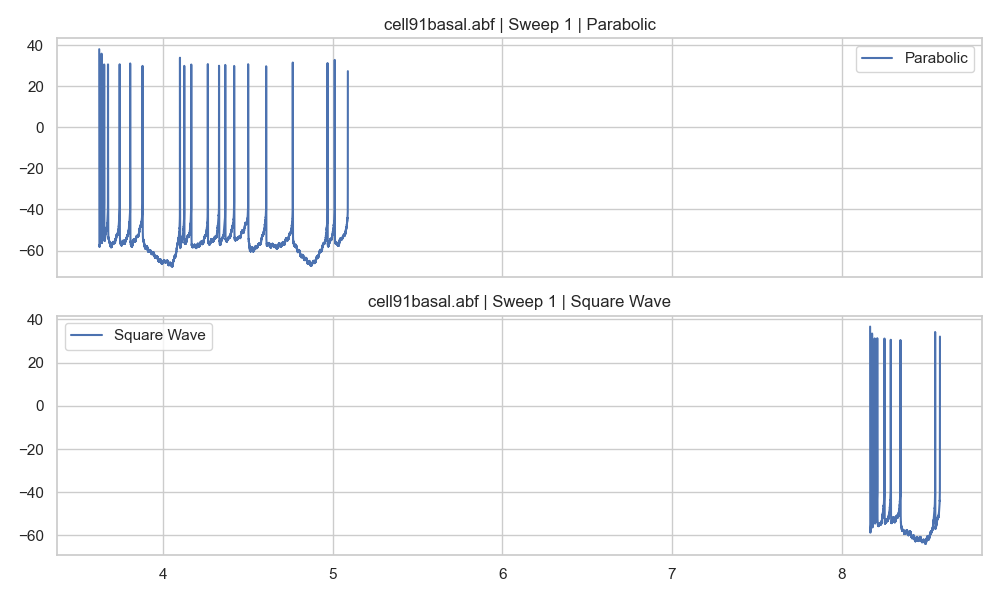

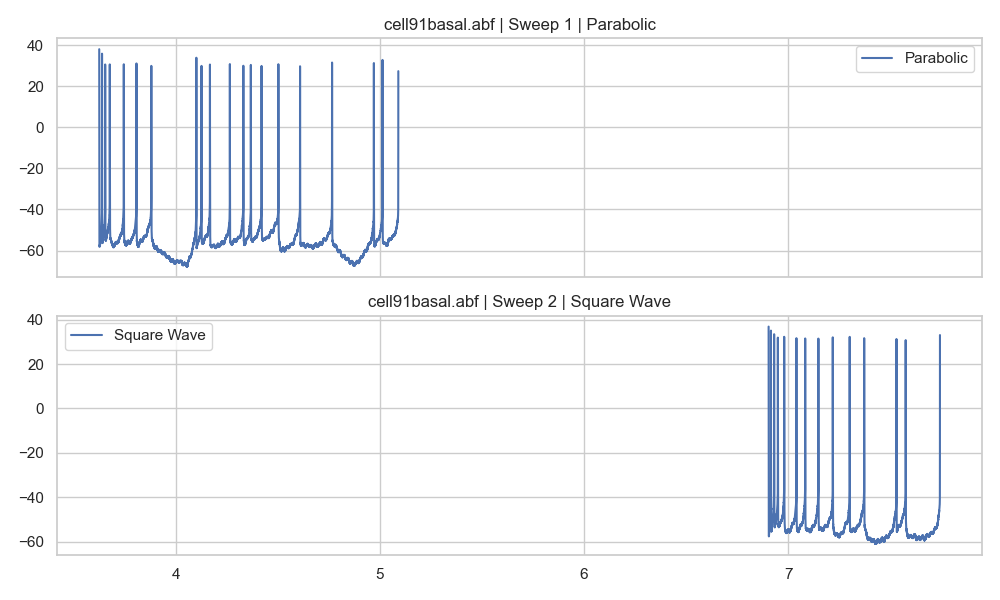

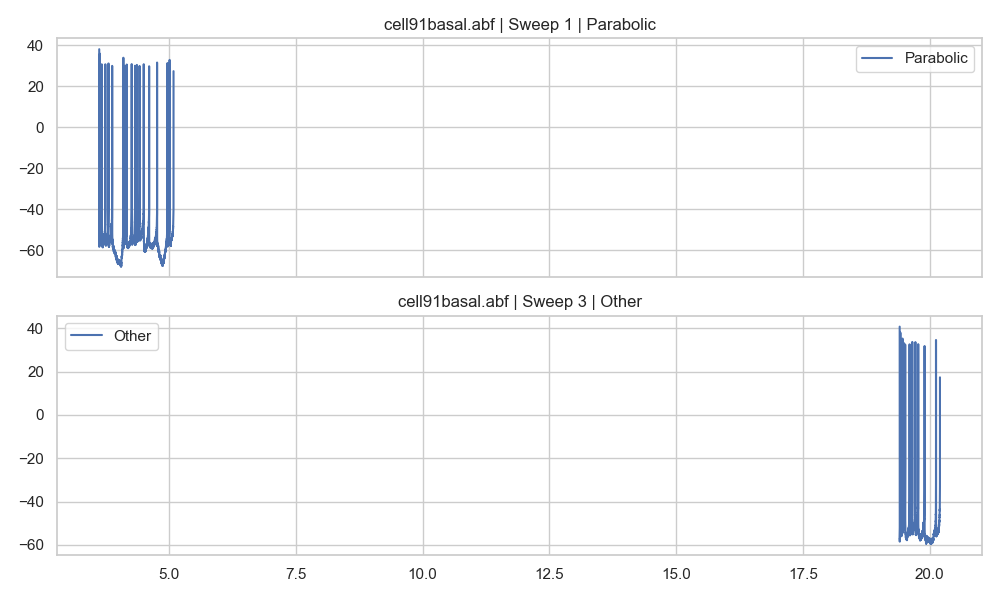

In [48]:
pairs = []
for cell, group in conflict_data.groupby("UMAP_bin"):
    types = group["Burst_Type"].unique()
    if len(types) > 1:
        for i, row1 in group.iterrows():
            for j, row2 in group.iterrows():
                if i < j and row1["Burst_Type"] != row2["Burst_Type"]:
                    pairs.append((row1, row2))

print(f"{len(pairs)} conflict pairs detected.")

for k, (row1, row2) in enumerate(pairs[:N]):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    for ax, row in zip(axs, [row1, row2]):
        file_path = os.path.join(folder_path, row["File_Name"])
        abf = pyabf.ABF(file_path)
        abf.setSweep(int(row["Sweep"]))
        time = abf.sweepX
        voltage = abf.sweepY
        mask = (time >= row["Segment_Start"]) & (time <= row["Segment_End"])
        ax.plot(time[mask], voltage[mask], label=row["Burst_Type"])
        ax.set_title(f"{row['File_Name']} | Sweep {row['Sweep']} | {row['Burst_Type']}")
        ax.legend()
    plt.tight_layout()
    plt.show()

- **Overlay All Conflicting Segments in Each UMAP Cell**

   Visualize all segments in a conflicting UMAP bin together for comparison.

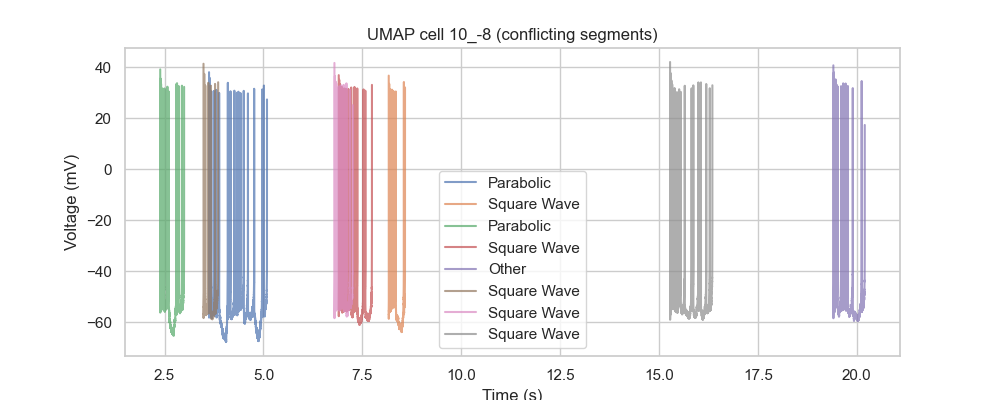

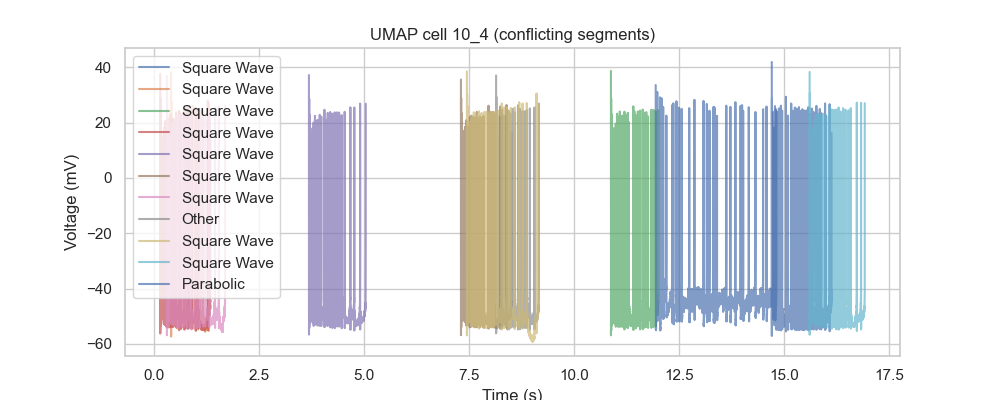

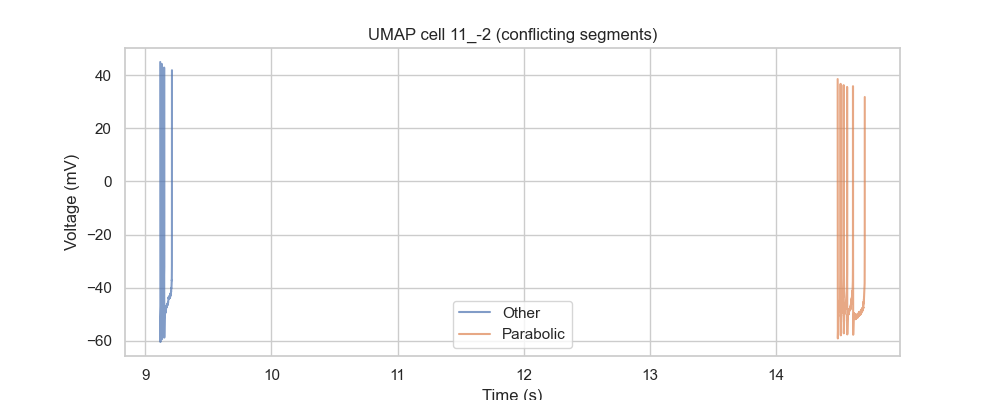

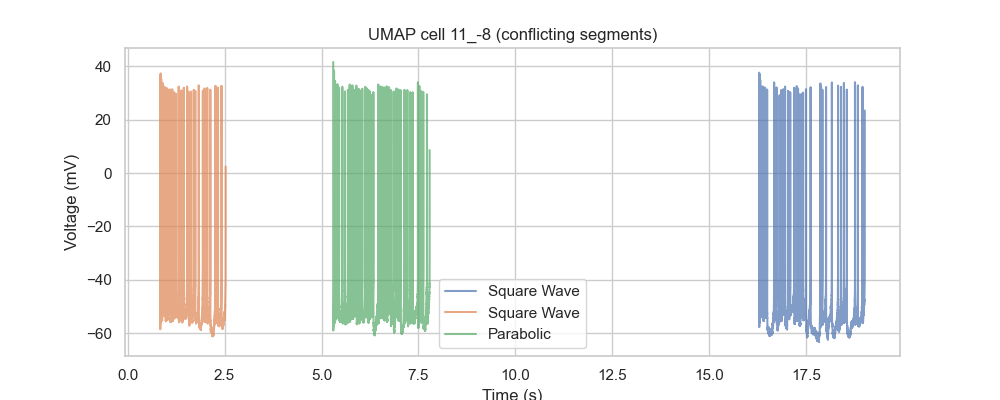

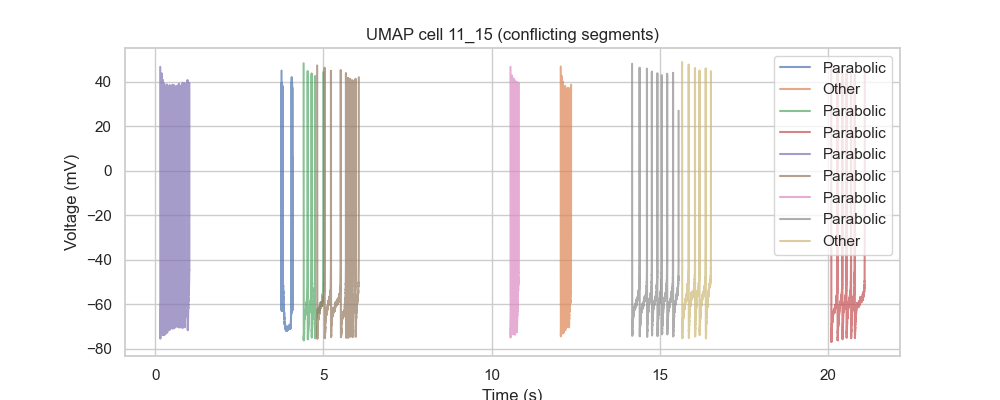

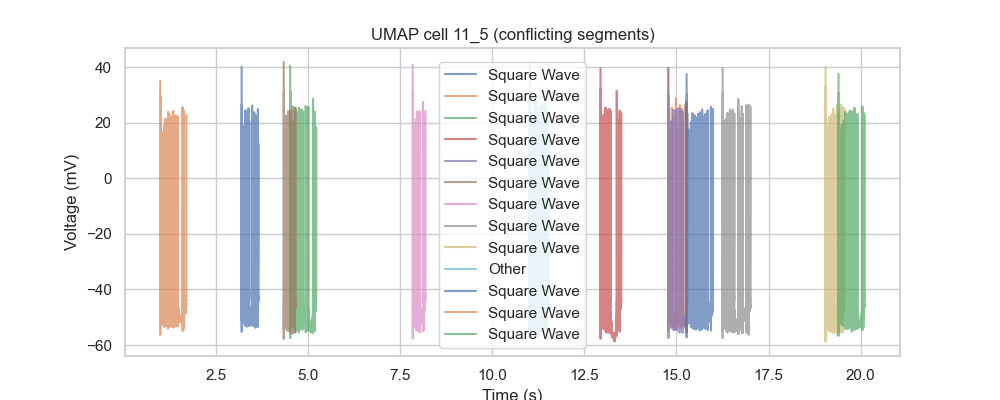

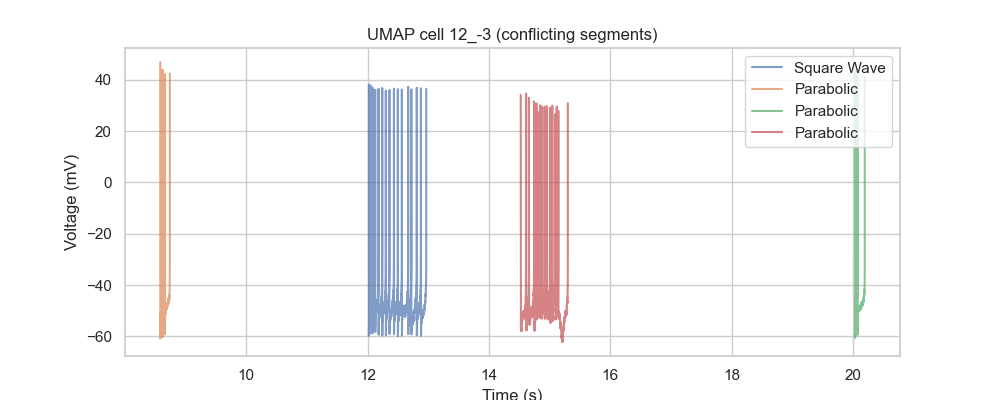

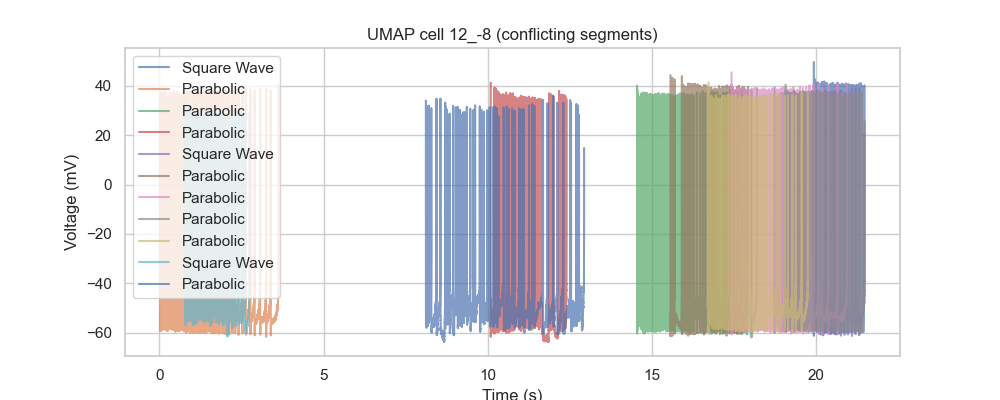

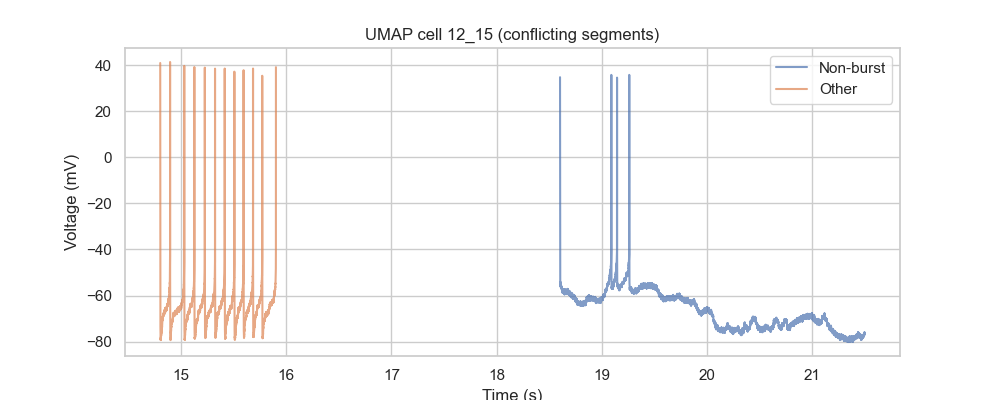

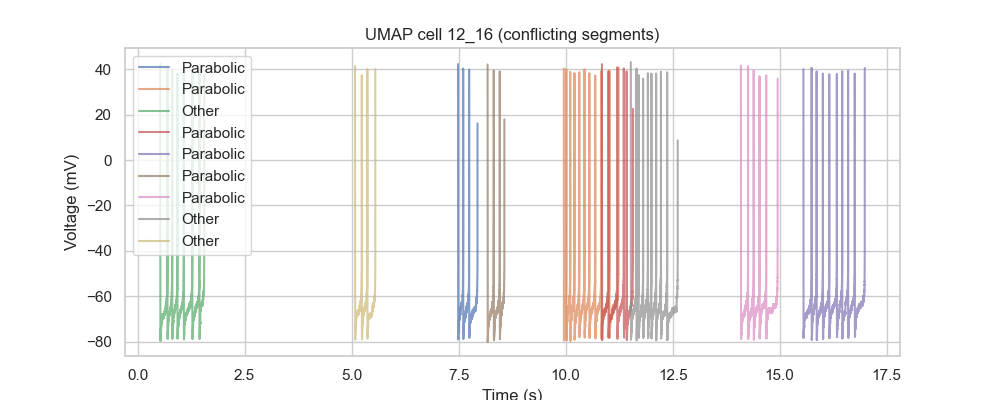

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



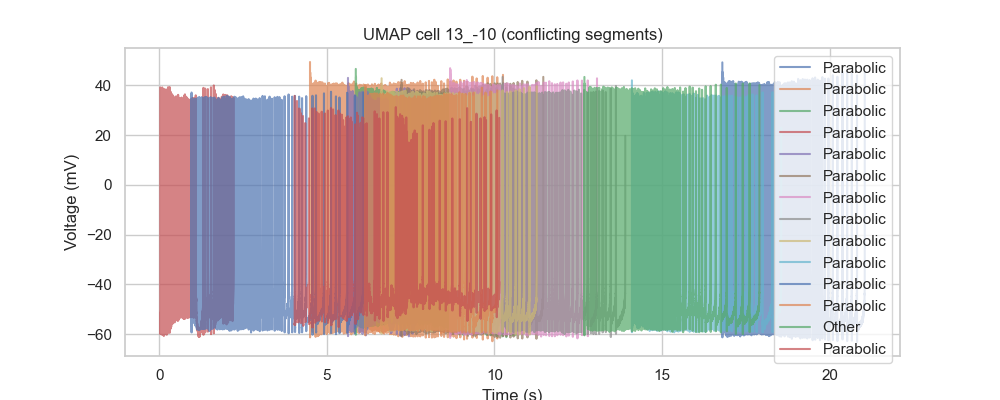

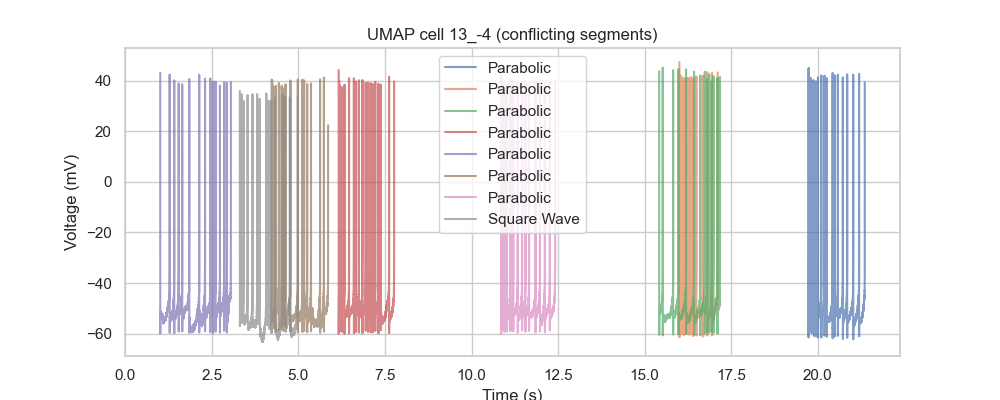

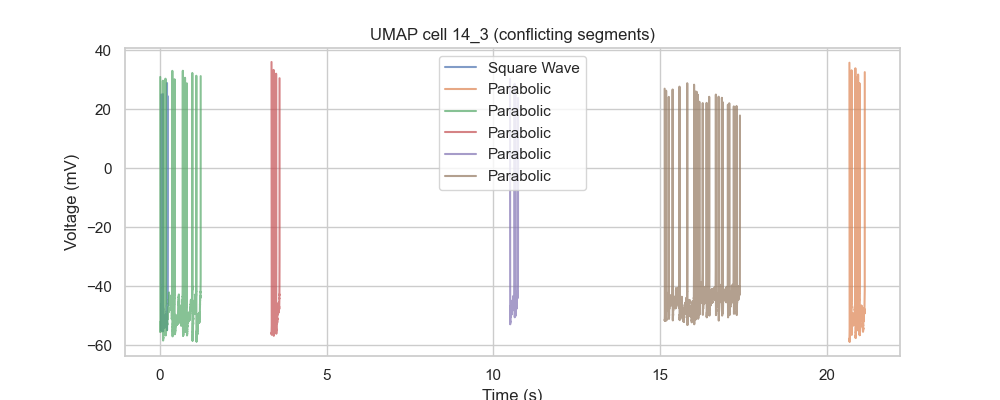

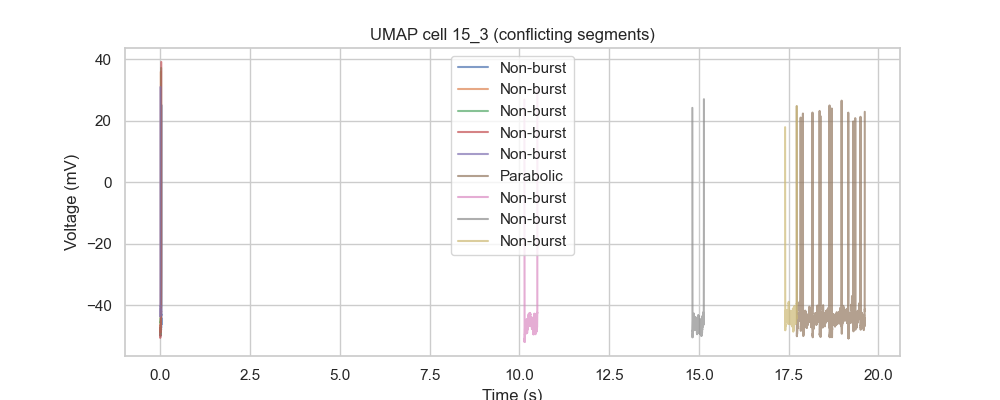

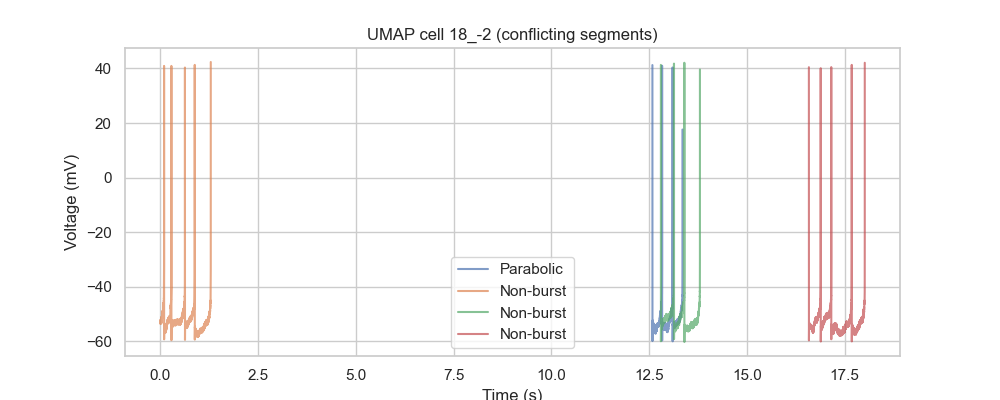

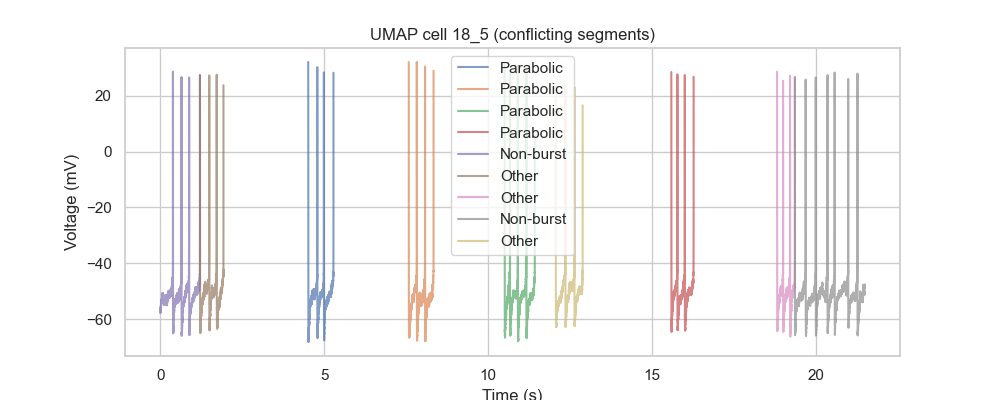

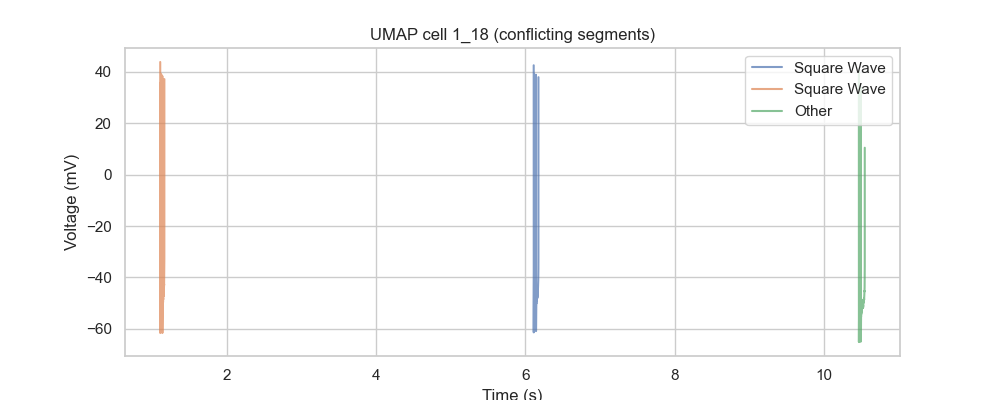

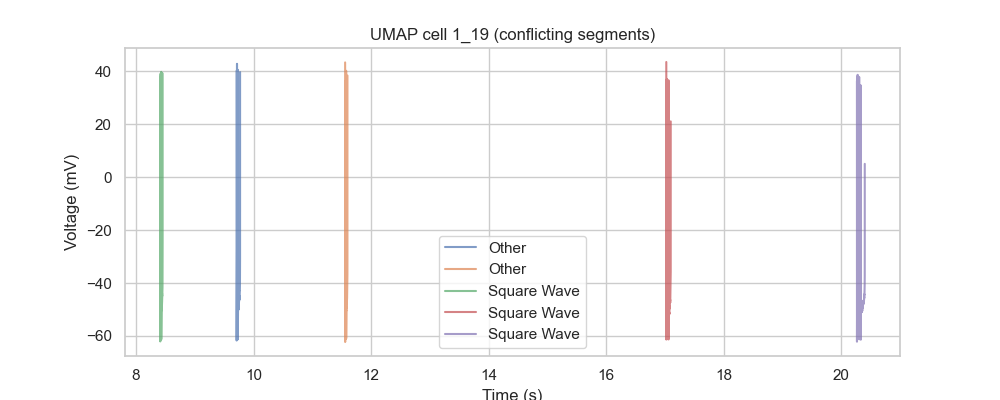

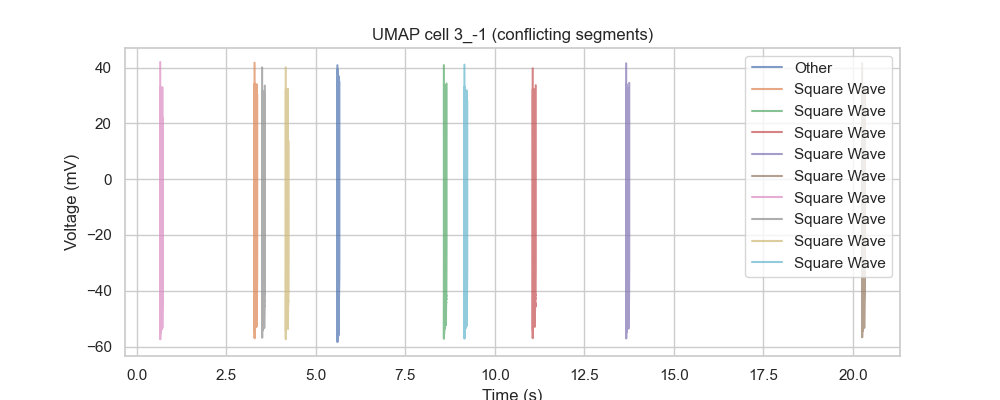

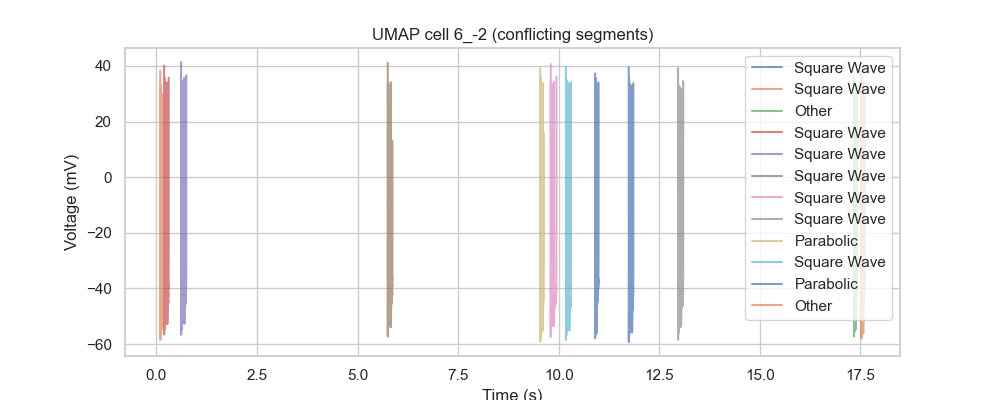

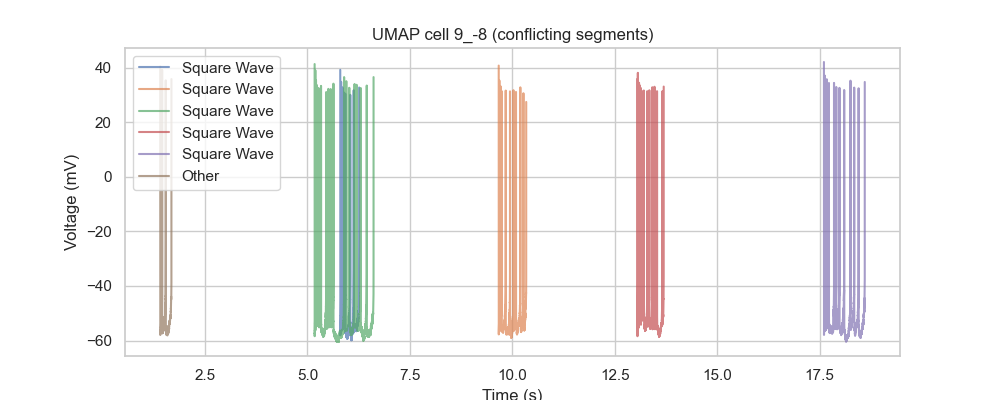

In [49]:
for cell, group in conflict_data.groupby("UMAP_bin"):
    if len(group["Burst_Type"].unique()) > 1:
        plt.figure(figsize=(10, 4))
        for _, row in group.iterrows():
            file_path = os.path.join(folder_path, row["File_Name"])
            abf = pyabf.ABF(file_path)
            abf.setSweep(int(row["Sweep"]))
            time = abf.sweepX
            voltage = abf.sweepY
            mask = (time >= row["Segment_Start"]) & (time <= row["Segment_End"])
            plt.plot(time[mask], voltage[mask], label=row["Burst_Type"], alpha=0.7)
        plt.title(f"UMAP cell {cell} (conflicting segments)")
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (mV)")
        plt.legend()
        plt.show()